In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,GlobalMaxPooling2D, Concatenate
from tensorflow.keras import applications
import numpy as np

In [2]:
print(tf.__version__)

2.6.3


In [3]:
ROWS=299
COLS=299
train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               preprocessing_function=preprocess_input)
train_gen = train_idg.flow_from_directory(
    '../input/datatask2/task2/train',
    target_size=(ROWS, COLS),
    batch_size = 64,
    shuffle=True
)
val_datagen = ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_directory(
    '../input/datatask2/task2/val',
    target_size=(ROWS, COLS),
    batch_size = 16
)

Found 14465 images belonging to 3 classes.
Found 1808 images belonging to 3 classes.


In [4]:
train_gen.class_indices

{'humanitarian': 0, 'non_informative': 1, 'structure': 2}

In [5]:
class_weights={0:2.0657,1:0.536,2:1.53448}

In [6]:
i=0
base_model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
for layers in base_model.layers:
    print(f'{i} : {layers.name}')
    if layers.name.find('batch_normalization')!=-1:
        print(True)
    i+=1

2022-05-16 11:56:05.630632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 11:56:05.709982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 11:56:05.710733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 11:56:05.712498: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 12s 0us/step
0 : input_1
1 : conv2d
2 : batch_normalization
True
3 : activation
4 : conv2d_1
5 : batch_normalization_1
True
6 : activation_1
7 : conv2d_2
8 : batch_normalization_2
True
9 : activation_2
10 : max_pooling2d
11 : conv2d_3
12 : batch_normalization_3
True
13 : activation_3
14 : conv2d_4
15 : batch_normalization_4
True
16 : activation_4
17 : max_pooling2d_1
18 : conv2d_8
19 : batch_normalization_8
True
20 : activation_8
21 : conv2d_6
22 : conv2d_9
23 : batch_normalization_6
True
24 : batch_normalization_9
True
25 : activation_6
26 : activation_9
27 : average_pooling2d
28 : conv2d_5
29 : conv2d_7
30 : conv2d_10
31 : conv2d_11
32 : batch_normalization_5
True
33 : batch_normalization_7
True
34 : batch_normalization_10
True
35 : batch_normalization_11
True
36 : activation_5
37 : activation_7
38 : activation_10
39 : activation_11
40 : mixed0
41 : conv2d_15
42 : batch_normalization_15
True
43 : activation_15
44 : conv2d_13
45 : c

In [7]:

input_shape = (ROWS, COLS, 3)
nclass = len(train_gen.class_indices)

i=0
base_model.trainable = True
for layers in base_model.layers:
    if i<200 or layers.name.find('batch_normalization')!=-1:
        layers.trainable=False
    else:
        layers.trainabale=True
    i+=1
add_model = Sequential()
add_model.add(base_model)
    
'''
base_model.trainable = True

add_model = Sequential()
add_model.add(base_model)
add_model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
add_model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
'''
add_model.add(GlobalMaxPooling2D())
add_model.add(Dense(1024,activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.SGD(),
              metrics=metrics)
model.summary()
import tensorflow.keras as keras


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 23,904,035
Trainable params: 16,896,003
Non-trainable params: 7,008,032
_________________________________________________________________


In [8]:
file_path="weights.best.hdf5"

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-loss-inception.h5', monitor='loss', mode='min', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valloss-inception.h5', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [es, mc,ms] #early


history = model.fit(train_gen,
                              validation_data=val_gen, 
                              epochs=100, 
                              shuffle=True, 
                              verbose=True,
                                class_weight=class_weights,
                              callbacks=callbacks_list)

2022-05-16 11:56:25.388208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-16 11:56:33.190925: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


227/227 [==============================] - 546s 2s/step - loss: 1.0061 - accuracy: 0.6371 - precison: 0.6906 - recall: 0.5500 - val_loss: 0.7231 - val_accuracy: 0.7008 - val_precison: 0.7270 - val_recall: 0.6598
Epoch 2/100
227/227 [==============================] - 438s 2s/step - loss: 0.6121 - accuracy: 0.7434 - precison: 0.7696 - recall: 0.7094 - val_loss: 0.5147 - val_accuracy: 0.7882 - val_precison: 0.8101 - val_recall: 0.7550
Epoch 3/100
227/227 [==============================] - 440s 2s/step - loss: 0.5470 - accuracy: 0.7729 - precison: 0.7930 - recall: 0.7476 - val_loss: 0.4818 - val_accuracy: 0.8009 - val_precison: 0.8215 - val_recall: 0.7865
Epoch 4/100
227/227 [==============================] - 442s 2s/step - loss: 0.5147 - accuracy: 0.7878 - precison: 0.8039 - recall: 0.7658 - val_loss: 0.5837 - val_accuracy: 0.7561 - val_precison: 0.7747 - val_recall: 0.7246
Epoch 5/100
227/227 [==============================] - 448s 2s/step - loss: 0.5180 - accuracy: 0.7953 - precison: 0.

In [9]:
savemodel = tf.keras.models.load_model('best_model_alt-valloss-inception.h5')

In [10]:
import os
predicted=[]
real=[]
for dir in os.listdir("../input/datatask2/task2/test"):
    if dir=='humanitarian':
        r=0
    elif dir =='non_informative':
        r=1
    else:
        r=2
    for path in os.listdir(f'../input/datatask2/task2/test/{dir}'):
        p=f'../input/datatask2/task2/test/{dir}/{path}'
        img = tf.keras.utils.load_img(
    p, target_size=(299, 299)
)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        img_array=preprocess_input(img_array)

        predictions = savemodel.predict(img_array)
        real.append(r)
        predicted.append(np.argmax(predictions))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [11]:
from sklearn import metrics
print(metrics.classification_report(real,predicted))
print(metrics.confusion_matrix(real,predicted))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       284
           1       0.92      0.85      0.88      1131
           2       0.75      0.87      0.81       394

    accuracy                           0.83      1809
   macro avg       0.77      0.80      0.78      1809
weighted avg       0.84      0.83      0.83      1809

[[193  61  30]
 [ 87 960  84]
 [ 27  23 344]]


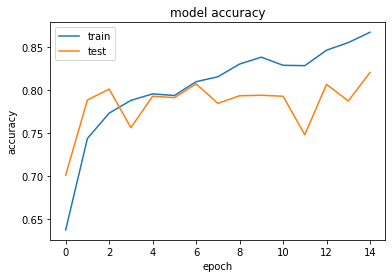

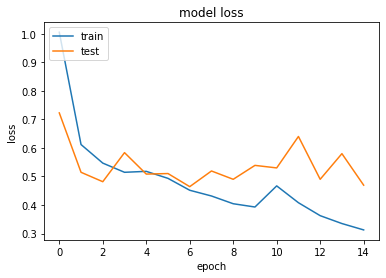

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

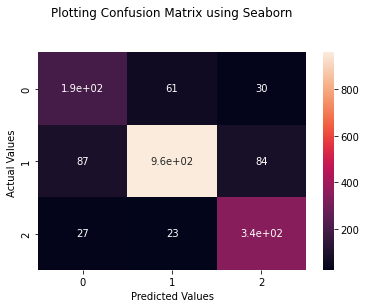

In [14]:
conf_matrix = (confusion_matrix(real, predicted))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True)

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');

# labels the boxes
